In [2]:
import json
from types import SimpleNamespace

import torch

import numpy as np
import ot
from pyitlib import discrete_random_variable as drv
from matplotlib import pyplot as plt
%matplotlib inline

from utils.solvers import FISTA
from model.lista import VIEncoderLISTA, LISTA
from model.vi_encoder import VIEncoder
from model.scheduler import CycleScheduler
from utils.dict_plotting import show_dict, show_phi_vid

[]

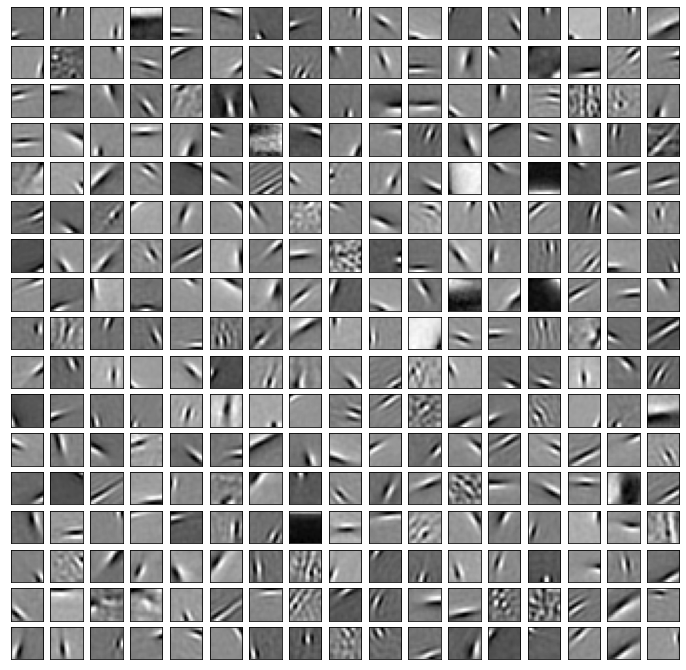

In [3]:
data_file = np.load("results/VI_laplacian_iwae/savefile_epoch199.npz")
phi = data_file['phi'][-1]

num_dictionaries = phi.shape[1]
patch_size = int(np.sqrt(phi.shape[0]))
fig = plt.figure(figsize=(12, 12))
for i in range(num_dictionaries):
    plt.subplot(int(np.sqrt(num_dictionaries)), int(np.sqrt(num_dictionaries)), i + 1)
    dict_element = phi[:, i].reshape(patch_size, patch_size)
    plt.imshow(dict_element, cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [4]:
code_count = 40000
real_images = True

if not real_images:
    true_support = 30
    random_codes = np.zeros((code_count, phi.shape[1]))
    support = np.random.randint(0, high=phi.shape[1], size=(code_count, true_support))
    for i in range(code_count):
        random_codes[i, support[i]] = np.random.randn(true_support)
    random_images = random_codes @ phi.T
else:
    data_file = f"data/imagepatches_16.np"
    if os.path.exists(data_file):
        with open(data_file, 'rb') as f:
            data_patches = np.load(f)
            val_patches = np.load(f)

    train_idx = np.linspace(1, data_patches.shape[0] - 1, code_count, dtype=int)
    random_images = data_patches[train_idx, :, :].reshape(-1, 16**2)
    random_images = random_images / np.linalg.norm(random_images, axis=1)[:, None]

    #random_codes = np.zeros((code_count, phi.shape[1]))
    #for i in range(code_count // 100):
    #    patches = random_images[i*100:(i+1)*100]
    #    random_codes[i*100:(i+1)*100] = FISTA(phi, patches.T, tau=solver_args.lambda_).T

In [5]:
epoch_load_list = ['0', '10', '50', '100', '200', '300', 'FISTA']
epoch_names = [n if n == 'FISTA' else 'Epoch ' + n for n in epoch_load_list]

train_patches = np.array(random_images)
base_run = "results/VI_gaussian-vampprior_iwae2/"

with open(base_run + "config.json") as json_data:
    config_data = json.load(json_data)
train_args = SimpleNamespace(**config_data['train'])
solver_args = SimpleNamespace(**config_data['solver'])

for idx, method in enumerate(epoch_load_list):
    multi_info = 0
    code_list = np.zeros((train_patches.shape[0], phi.shape[1]))
    kl_collapse = np.zeros(phi.shape[1])
    coeff_collapse = np.zeros(phi.shape[1])

    for i in range(train_patches.shape[0] // train_args.batch_size):
        patches = train_patches[i * train_args.batch_size:(i + 1) * train_args.batch_size].reshape(train_args.batch_size, -1).T

        if method == 'FISTA':
            code_est = FISTA(phi, patches, tau=solver_args.lambda_).T
        else:
            with torch.no_grad():
                encoder = VIEncoder(train_args.patch_size, train_args.dict_size, solver_args).to('cuda:1')
                encoder.load_state_dict(torch.load(base_run + f"encoderstate_epoch{method}.pt")['model_state'])
                
                patches_cu = torch.tensor(patches.T).float().to('cuda:1')
                dict_cu = torch.tensor(phi, device='cuda:1').float()

                iwae_loss, recon_loss, kl_loss, b_cu = encoder(patches_cu, dict_cu)
                code_est = b_cu.detach().cpu().numpy()

                if solver_args.prior == "laplacian":
                    feat = encoder.enc(patches_cu)
                    logscale, mu = encoder.shift(feat), encoder.scale(feat)
                    scale = torch.exp(logscale)
                    kl = (-1 - logscale + mu.abs() + scale*(-mu.abs() / scale).exp())
                elif solver_args.prior == "gaussian":
                    feat = encoder.enc(patches_cu)
                    logvar, mu = encoder.shift(feat), encoder.scale(feat)        
                    kl = - 0.5 * (1 + logvar - (mu ** 2) - logvar.exp())
                elif solver_args.prior == "vampprior":
                    feat = encoder.enc(patches_cu)
                    logvar, mu = encoder.shift(feat), encoder.scale(feat)
                    
                    pseudo_feat = encoder.enc(encoder.pseudo_inputs)
                    pseudo_logvar, pseudo_mu = encoder.shift(pseudo_feat).unsqueeze(0), encoder.scale(pseudo_feat).unsqueeze(0)               

                    scale = torch.exp(0.5*logvar)
                    eps = torch.randn_like(scale)
                    z = mu + eps*scale 

                    log_p_z = -0.5 * (pseudo_logvar + torch.pow(z.unsqueeze(1) - pseudo_mu, 2 ) / torch.exp(pseudo_logvar))
                    log_p_z = torch.logsumexp(log_p_z - np.log(solver_args.num_pseudo_inputs), dim=-2)
                    log_q_z = -0.5 * (logvar + torch.pow(z - mu, 2 ) / torch.exp(logvar))
                    kl = log_q_z - log_p_z

            for k in range(phi.shape[1]):
                kl_collapse[k] += (kl[:, k] <= 1e-2).sum()
                coeff_collapse[k] += (np.abs(code_est[:, k]) <= 5e-2).sum()
        
        code_list[i*train_args.batch_size:(i+1)*train_args.batch_size] = code_est

    kl_collapse /= train_patches.shape[0]
    coeff_collapse /= train_patches.shape[0]
    percent_collapse = 100. * (kl_collapse >= 0.99).sum() / phi.shape[1]
    per_coeff_collapse = 100. * (coeff_collapse >= 0.95).sum() / phi.shape[1]
    multi_info = drv.information_multi(code_list.T)
    print(f"{epoch_names[idx]}, multi-information: {multi_info:.3E}, % posterior collapse: {percent_collapse:.2f}%, % coeff collapse: {per_coeff_collapse:.2f}%")
print()

Epoch 0, multi-information: 4.257E+03, % posterior collapse: 34.95%, % coeff collapse: 0.00%
Epoch 10, multi-information: 4.248E+03, % posterior collapse: 11.76%, % coeff collapse: 0.00%
Epoch 50, multi-information: 5.234E+02, % posterior collapse: 0.00%, % coeff collapse: 99.31%
Epoch 100, multi-information: 4.178E+02, % posterior collapse: 0.00%, % coeff collapse: 99.65%
Epoch 200, multi-information: 3.079E+02, % posterior collapse: 0.00%, % coeff collapse: 100.00%
Epoch 300, multi-information: 2.630E+02, % posterior collapse: 0.00%, % coeff collapse: 100.00%
FISTA, multi-information: 4.706E+02, % posterior collapse: 0.00%, % coeff collapse: 0.00%



KeyboardInterrupt: 

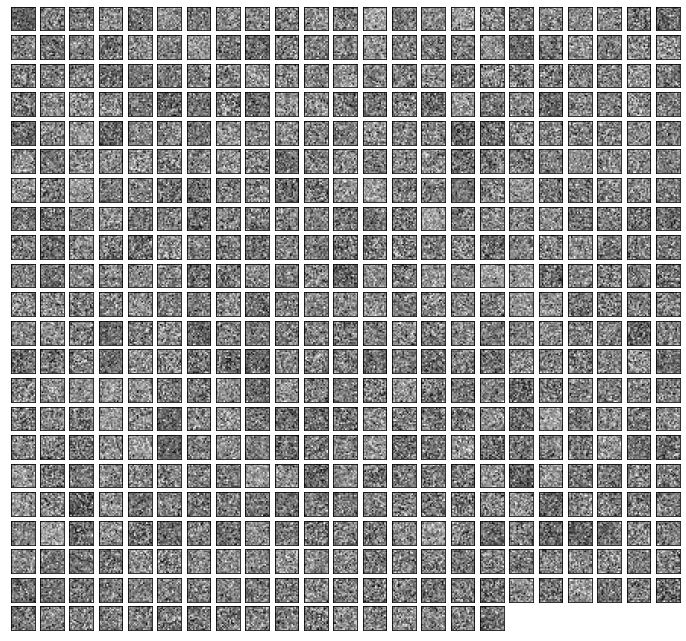

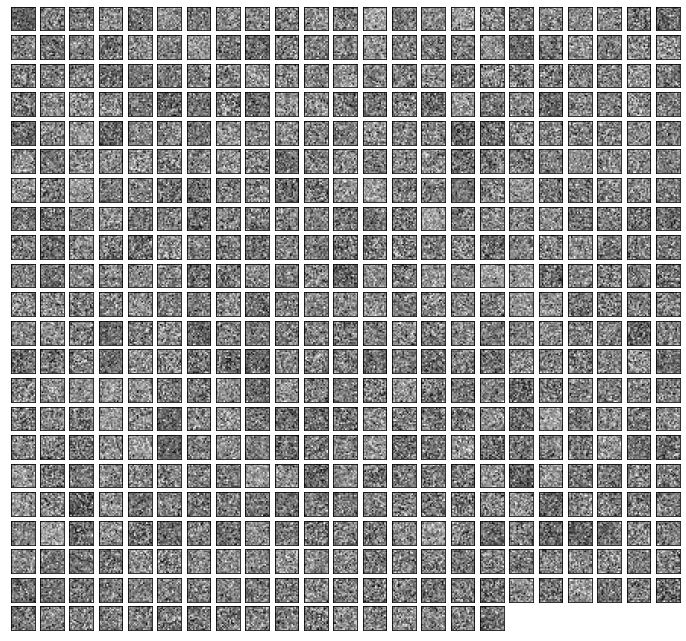

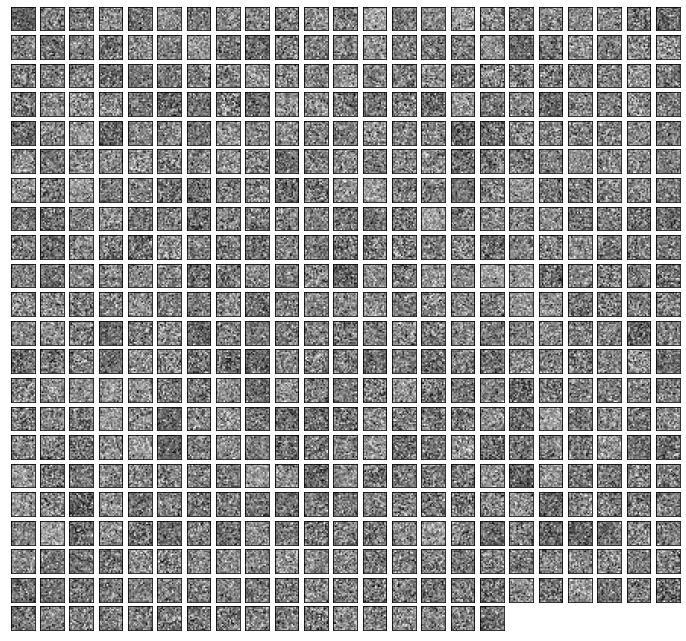

In [33]:
base_run = "results/VI_gaussian-vampprior_iwae/"

for idx, method in enumerate(epoch_load_list):
    encoder = VIEncoder(train_args.patch_size, train_args.dict_size, solver_args).to('cuda:1')
    encoder.load_state_dict(torch.load(base_run + f"encoderstate_epoch{method}.pt")['model_state'])

    pseudo_input = encoder.pseudo_inputs.data
    fig = plt.figure(figsize=(12, 12))
    for i in range(500):
        plt.subplot(23, 23, i + 1)
        dict_element = pseudo_input[i].detach().cpu().numpy().reshape(patch_size, patch_size)
        plt.imshow(dict_element, cmap='gray')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])